## Rigid alignment as preprocessing

Work based on Lukas' functions

In [24]:
import tifffile 
from matplotlib import pyplot as plt
#print('plt: ' + plt.__version__)
import cv2
print('cv2: ' + cv2.__version__)
import numpy as np
print('np: ' + np.__version__)
import math
import sys
import os
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import get_single_volume
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import get_single_volume
from skimage.filters import difference_of_gaussians
from skimage import exposure
from tqdm import tqdm
from DLC_for_WBFM.utils.visualization.plot_traces import set_big_font

cv2: 3.4.2
np: 1.19.2


In [2]:
# The whole filter procedure as function:
# The image has to be square
# Option for the future: add pixel on the smaller side to make it square and crop after filtering
# the fft filter is used to prepare the image

# The whole fft filter procedure as function:
# The image gets extended to be square.
# To avoid corner artefacts the background is set to the value of the lowest pixel.
# highFrequ: number for the low pass filter (~3)
# lowFrequ: number for the high pass filter (~5000) --> also acts like background subtraction
def filterImage(filterImg, highFrequ, lowFrequ):
    # get Image size
    (x, y) = filterImg.shape
    # get image avarage
    # get some Background aproximation:
    min, max, minPt, maxPt = cv2.minMaxLoc(filterImg)
    avr = min
    #avr = np.average(filterImg)
    #avr = 0
    if x > y:
        tempImage = np.full((x, x), avr)
        tempImage[:,int((x-y)/2):y+int((x-y)/2)] = filterImg
        size = x
    elif y > x:
        tempImage = np.full((y, y), avr)
        tempImage[int((y-x)/2):x+int((y-x)/2)] = filterImg
        size = y
    else:
        tempImage = filterImg
        size = x
    # set filter values
    rhigh = highFrequ # how narrower the window is
    rlow = lowFrequ # how broad the window is
    # function to generate the mask (window)
    ham = np.hamming(size)[:,None] # 1D hamming
    ham2dhigh = np.sqrt(np.dot(ham, ham.T)) ** rhigh # expand to 2D hamming
    ham2dlow = np.sqrt(np.dot(ham, ham.T)) ** rlow
    ham2d = ham2dhigh - ham2dlow
    # the mask determines the filter in frequency space.
    # with different filter regular image distorgen can be removed
    # see fourier space filters
    # calculate fourier transform
    f = cv2.dft(tempImage.astype('float32'), flags=cv2.DFT_COMPLEX_OUTPUT)
    # reorder result quarters (the 4 quardrants are in wrong order)
    f_shifted = np.fft.fftshift(f)
    f_complex = f_shifted[:,:,0]*1j + f_shifted[:,:,1]
    # apply filter mask
    f_filtered = ham2d * f_complex
    # reorder result
    f_filtered_shifted = np.fft.fftshift(f_filtered)
    # inverse F.T.
    inv_img = np.fft.ifft2(f_filtered_shifted)
    # take absolut values
    filtered_img = np.abs(inv_img)
    # return result
    if x > y:
        return filtered_img[:,int((x-y)/2):y+int((x-y)/2)]
    if y > x:
        return filtered_img[int((y-x)/2):x+int((y-x)/2)]
    
    filtered_img = cv2.bilateralFilter(filtered_img.astype('float32'), d=9, sigmaColor=50, sigmaSpace=3).astype('uint8')
    return filtered_img

# def filterImage(filterImg, low_sigma, high_sigma):
#     # TODO: Make sure the intensities are not rescaled here
#     original_range = (np.min(filterImg), np.max(filterImg))
#     filterImg = difference_of_gaussians(filterImg, low_sigma, high_sigma)
#     filterImg = exposure.rescale_intensity(img_as_ubyte(filterImg), in_range=original_range)
#     return filterImg

# def filterImage(filterImg, d, sigmaSpace):
# #     filterImg = cv2.bilateralFilter(filterImg.astype('float32'), d=9, sigmaSpace=3).astype('uint8')
#     return filterImg

def filter_stack(stackToAlign):
    # First, filter all planes
    filtered_stack = np.array(stackToAlign)
    opt = {'highFrequ':2.0, 'lowFrequ':5000.0}
#     opt = {'low_sigma':1.0, 'high_sigma':30.0}
#     opt = {'d':1.0, 'sigmaSpace':30.0}
    for i in range(stackToAlign.shape[0]):
        filtered_stack[i,...] = filterImage(filtered_stack[i,...], **opt)
    
    return filtered_stack

In [3]:
# def mergeWarpMatrix(firstMat, secondMat):
#     firstMul = np.identity(3)
#     secondMul = np.identity(3)
#     (x, y) = firstMat.shape
#     if x < 3:
#         firstMul[0:2,:] = firstMat
#     else:
#         firstMul = firstMat
#     (x, y) = secondMat.shape
#     if x < 3:
#         secondMul[0:2,:] = secondMat
#     else:
#         firstMul = secondMat
#     combinedMat = secondMul.dot(firstMul)
#     return combinedMat[0:2,:]

# this function calculates the overall transformation of two given warp matrix
# the warp matrix which combines both given warp matrix is given back
def mergeWarpMatrix(firstMat, secondMat):
    # creaty identity matrix of size 3x3
    firstMul = np.identity(3)
    secondMul = np.identity(3)
    # copy the given matrix into the 3x3 matrix
    # it is necessary to distinguishe by size
    (x, y) = firstMat.shape
    affine = True
    if x < 3:
        firstMul[0:2,:] = firstMat
    else:
        affine = False
        firstMul = firstMat
    (x, y) = secondMat.shape
    if x < 3:
        secondMul[0:2,:] = secondMat
    else:
        affine = False
        firstMul = secondMat
    # calculate the dot product of firstMat and secondMat
    combinedMat = secondMul.dot(firstMul)
    # return the affine matrix
    if affine:
        return combinedMat[0:2,:]
    # return the homography matrix
    return combinedMat

In [4]:
def align_two_images(im0, im1, matches_to_keep=0.2, max_features=10000, use_GMS=False, DEBUG=False):
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(max_features)
#     points1 = np.zeros((1, 2), dtype=np.float32)
#     points2 = np.zeros((1, 2), dtype=np.float32)
#     orb.setFastThreshold(0)
    
    keypoints1, descriptors1 = orb.detectAndCompute(im0, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im1, None)
    if descriptors1 is None or descriptors2 is None:
        return None, 1
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
#     matcher = cv2.BFMatcher_create(normType =cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(descriptors1, descriptors2, None)
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
    numGoodMatches = int(len(matches) * matches_to_keep)
    matches = matches[:numGoodMatches]
    if use_GMS:
        opt = {'keypoints1':keypoints1,
               'keypoints2':keypoints2,
               'matches1to2':matches,
               'withRotation':False,
               'thresholdFactor':6.0}
        matches = cv2.xfeatures2d.matchGMS(im0.shape, im1.shape, **opt)
    if len(matches) < 3:
        return None, 2
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    # Align lists of matches
    for m, match in enumerate(matches):
        points1[m, :] = keypoints1[match.queryIdx].pt
        points2[m, :] = keypoints2[match.trainIdx].pt
#     points1 = np.concatenate((points1, tempPoints1), axis=0)
#     points2 = np.concatenate((points2, tempPoints2), axis=0)
    if len(points1) < 3 or len(points2) < 3:
        return None, 3
    # Calculate the actual transformation
    h = cv2.estimateRigidTransform(points2[1:], points1[1:], False)
#     h, inliers = cv2.estimateAffinePartial2D(points1,points2, confidence=0.99)
#     h, inliers = cv2.estimateAffinePartial2D(points1,points2, method=cv2.LMEDS)
#     h, inliers = cv2.estimateAffinePartial2D(points1,points2, method=cv2.LMEDS, confidence=0.999)
#     print(f"Found {np.count_nonzero([i[0] for i in inliers])} inliers")
    if DEBUG:
        print("Plotting...")
#         print(points2)
        x, y = points2[:,0], points2[:,1]
        diff = points2-points1
        dx, dy = diff[:,0], diff[:,1]
        plt.quiver(x,y,dx,dy)
        plt.show()

    return h, 0

# def align_two_images(im0, im1):
#     h = cv2.estimateRigidTransform(im1, im0, False)
#     return h, 0

In [5]:
def eccImagesWarpMat(im1_gray, im2_gray, warp_mode=cv2.MOTION_EUCLIDEAN, termination_eps=1e-3):
    # prefilter Images, helps to correlate
    # for best performance a filter which keeps good features to align should be used.
    # for example: with strong differences in brightnes but identical edges an edge dector can be used to filter.
    
    # Find size of image1
    sz = im1_gray.shape

    # Define the motion model (more freedom needs more computational time)
    # Translation, Euclidean, Affine, Homography
    # given by Parameter
    # warp_mode = cv2.MOTION_EUCLIDEAN
    # (as function parameter)
    
    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 10000;

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    # (precision vs computational time)
    # termination_eps = 1e-4;
    # (as function parameter)
 
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
 
    # Run the ECC algorithm. The results are stored in warp_matrix.
#     warp_mode = cv2.MOTION_AFFINE
    (cc, warp_matrix) = cv2.findTransformECC(im1_gray.astype('float32'),im2_gray.astype('float32'),warp_matrix, warp_mode, criteria, None)
    
    
    # example to execute the transformation
    #if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography
        #im2_aligned = cv2.warpPerspective (im2_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    #else :
        # Use warpAffine for Translation, Euclidean and Affine
        #im2_aligned = cv2.warpAffine(im2_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    return warp_matrix

In [6]:
def align_stack(stackToAlign):
    sz = stackToAlign[0].shape
    # align volumes, starting from the center
    centerPlane = int(stackToAlign.shape[0]/2)
    alignedRawVol = np.empty_like(stackToAlign)
    alignedRawVol[centerPlane] = stackToAlign[centerPlane]
    
    # From centerPlane to 0
    # Calculates the matrix per plane, and cumulatively multiplies them
    warpMat = np.identity(3)[0:2,:]
    for i in tqdm(range(centerPlane,0,-1)):
        im_next, im_prev = stackToAlign[i-1], stackToAlign[i]
#         warpNew, error_mode = align_two_images(im0, im1)
        warpNew = eccImagesWarpMat(im_prev, im_next)
        if warpNew is None:
            print(f"Skipping plane {i}, error {error_mode}")
            warpNew = np.identity(3)[0:2,:]
        
        warpMat = mergeWarpMatrix(warpMat, warpNew)
        alignedRawVol[i-1] = cv2.warpAffine(im_next, warpMat, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    # From centerPlane to end (usually 33)
    warpMat = np.identity(3)[0:2,:]
    for i in tqdm(range(centerPlane,(stackToAlign.shape[0]-1))):
        im_prev, im_next = stackToAlign[i], stackToAlign[i+1]
#         warpNew, error_mode = align_two_images(im0, im1)
        warpNew = eccImagesWarpMat(im_prev, im_next)
        if warpNew is None:
            print(f"Skipping plane {i}, error {error_mode}")
            warpNew = np.identity(3)[0:2,:]

        warpMat = mergeWarpMatrix(warpMat, warpNew)
        alignedRawVol[i+1] = cv2.warpAffine(im_next, warpMat, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        
    return alignedRawVol

## Actually align

Text(0.5, 1.0, 'Raw data')

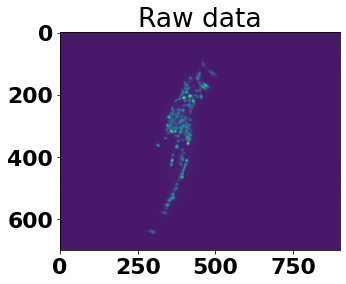

In [32]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)

dat = get_single_volume(btf_fname_red, 21, 33, alpha=1.0, dtype='uint16')
dat = dat[2:]
plt.imshow(np.max(dat,axis=0))
plt.title('Raw data')

In [33]:
# print("Filtering... takes a while")
dat_filter = filter_stack(dat)
print("Finished filtering")

Finished filtering


In [34]:

dat_aligned = align_stack(dat_filter)
# dat_aligned = alignSeries(dat)

100%|███████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.20it/s]


Text(0.5, 1.0, 'Aligned data max projection')

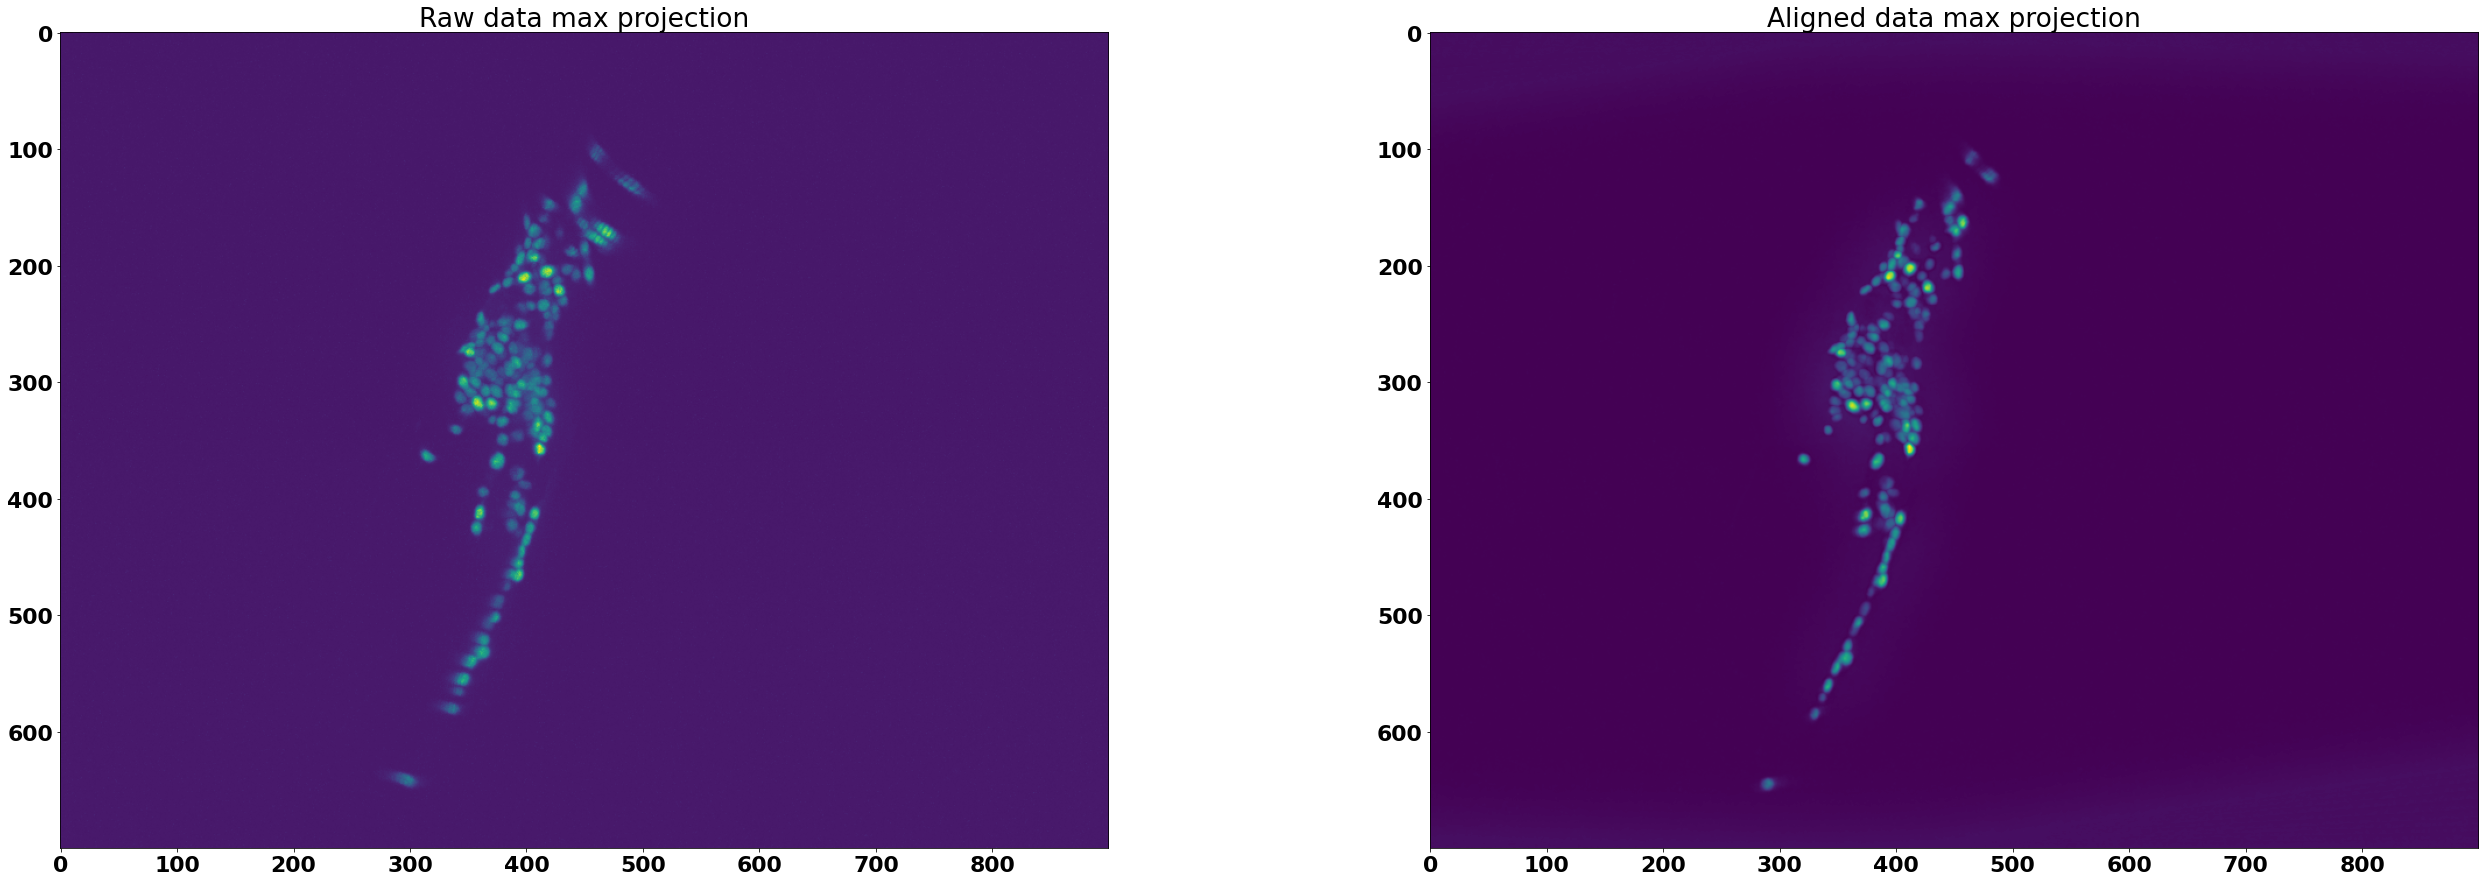

In [35]:
%matplotlib inline
plt.figure(figsize=(45,15))
set_big_font()

plt.subplot(121)
plt.imshow(np.max(dat,axis=0))
plt.title('Raw data max projection')

plt.subplot(122)
plt.imshow(np.max(dat_aligned,axis=0))
plt.title('Aligned data max projection')


In [76]:

plt.imshow(np.max(dat,axis=0))
plt.title('Original data')

Text(0.5, 1.0, 'Original data')

In [154]:
from skimage.util import img_as_ubyte
im_filter = filterImage(dat[14,...], 1, 10)
plt.imshow(img_as_ubyte(im_filter))

In [238]:
# for i in range(2,30,5):
#     print(f"Larger gaussian is: {i}")
#     %timeit filterImage(dat[14,...], 1, i)

Larger gaussian is: 2
72.9 ms ± 567 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Larger gaussian is: 7
104 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Larger gaussian is: 12
136 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Larger gaussian is: 17
165 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Larger gaussian is: 22
198 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Larger gaussian is: 27
232 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Aligned data')

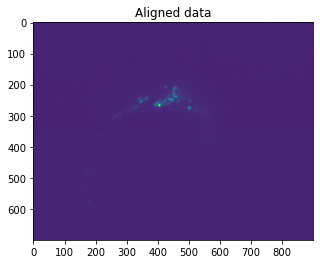

In [20]:
%matplotlib inline
i = 20
plt.imshow(dat[i,...])
plt.title('Aligned data')

In [177]:
plt.imshow(dat[i,...])